Project 2: Ames Housing Data and Kaggle Challenge

Problem Statement:
    To create a regression model to predict the sales price for each house

In [1]:
import random as rand
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import imp
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn import metrics
from sklearn import feature_extraction 
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
ames_train = pd.read_csv('datasets/train.csv')

In [3]:
def explore(df):
    print(df.shape)
    print("")
    print(df.head())
    print("")
    print(df.dtypes)
    print("")
    print(df.isnull().sum())
    print("")
    print(df.describe())
    
explore(ames_train)

(2051, 81)

    Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  Condition 1 Condition 2 Bldg Type House Style  Overall Qual 

In [4]:
#Replacing the np.nan cells to their respective column values

ames_train['Lot Frontage'] = ames_train['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_train['Alley'] = ames_train['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 22 entries that are tied to each other
ames_train['Mas Vnr Type'] = ames_train['Mas Vnr Type'].replace({np.nan:'None'})
ames_train['Mas Vnr Area'] = ames_train['Mas Vnr Area'].replace({np.nan:0})

#55 entries without basement
ames_train['Bsmt Qual'] = ames_train['Bsmt Qual'].replace({np.nan:'NA'})
ames_train['Bsmt Cond'] = ames_train['Bsmt Cond'].replace({np.nan:'NA'})

#These three cells has a basement but their exposure is unknown
ames_train.iloc[1456, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1547, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'
ames_train.iloc[1997, ames_train.columns.get_loc('Bsmt Exposure')] = 'No'

#entries without basement
ames_train['Bsmt Exposure'] = ames_train['Bsmt Exposure'].replace({np.nan:'NA'})
ames_train['BsmtFin Type 1'] = ames_train['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 1'] = ames_train['BsmtFin SF 1'].replace({np.nan:0})
ames_train['BsmtFin Type 2'] = ames_train['BsmtFin Type 2'].replace({np.nan:'NA'})
ames_train['BsmtFin SF 2'] = ames_train['BsmtFin SF 2'].replace({np.nan:0})
ames_train['Bsmt Unf SF'] = ames_train['Bsmt Unf SF'].replace({np.nan:0})
ames_train['Total Bsmt SF'] = ames_train['Total Bsmt SF'].replace({np.nan:0})
ames_train['Bsmt Full Bath'] = ames_train['Bsmt Full Bath'].replace({np.nan:0})
ames_train['Bsmt Half Bath'] = ames_train['Bsmt Half Bath'].replace({np.nan:0})

#All fireplace Qu with np.nan is does not have a fireplace.
ames_train['Fireplace Qu'] = ames_train['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row1712, does not have a garage. 
ames_train['Garage Type'] = ames_train['Garage Type'].replace({np.nan:'NA'})
ames_train.iloc[1712, ames_train.columns.get_loc('Garage Yr Blt')] = ames_train.iloc[1712, ames_train.columns.get_loc('Year Remod/Add')]
ames_train['Garage Yr Blt'] = ames_train['Garage Yr Blt'].replace({np.nan:0})
ames_train['Garage Finish'] = ames_train['Garage Finish'].replace({np.nan:'NA'})
ames_train['Garage Cars'] = ames_train['Garage Cars'].replace({np.nan:0})
ames_train['Garage Area'] = ames_train['Garage Area'].replace({np.nan:0})
ames_train['Garage Qual'] = ames_train['Garage Qual'].replace({np.nan:'NA'})
ames_train['Garage Cond'] = ames_train['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_train['Pool QC'] = ames_train['Pool QC'].replace({np.nan:'NA'})
ames_train['Fence'] = ames_train['Fence'].replace({np.nan:'NA'})
ames_train['Misc Feature'] = ames_train['Misc Feature'].replace({np.nan:'NA'})

In [5]:
#encoding each ordinal categorical features, full glossary in readme
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


def transform(col):
    for i in col:
        le.fit(ames_train[i])
        list(le.classes_)
        ames_train[i] = le.transform(ames_train[i])

columns = ['Lot Shape',
           'Utilities',
           'Land Slope',
           'Exter Qual',
           'Exter Cond',
           'Bsmt Qual',
           'Bsmt Cond',
           'Bsmt Exposure',
           'BsmtFin Type 1',
           'BsmtFin Type 2',
           'Heating QC',
           'Electrical',
           'Kitchen Qual',
           'Functional',
           'Fireplace Qu',
           'Garage Finish',
           'Garage Qual',
           'Garage Cond',
           'Paved Drive',
           'Pool QC',
           'Fence']

transform(columns)

In [6]:
column2= ['MS SubClass',
         'MS Zoning',
         'Street',
         'Alley',
         'Land Contour',
         'Lot Config',
         'Neighborhood',
         'Condition 1',
         'Condition 2',
         'Bldg Type',
         'House Style',
         'Roof Style',
         'Roof Matl',
         'Exterior 1st',
         'Exterior 2nd',
         'Mas Vnr Type',
         'Foundation',
         'Heating',
         'Central Air',
         'Garage Type',
         'Misc Feature',
         'Sale Type']

ames_train = pd.get_dummies(data = ames_train, prefix=column2, columns = column2, drop_first=True)

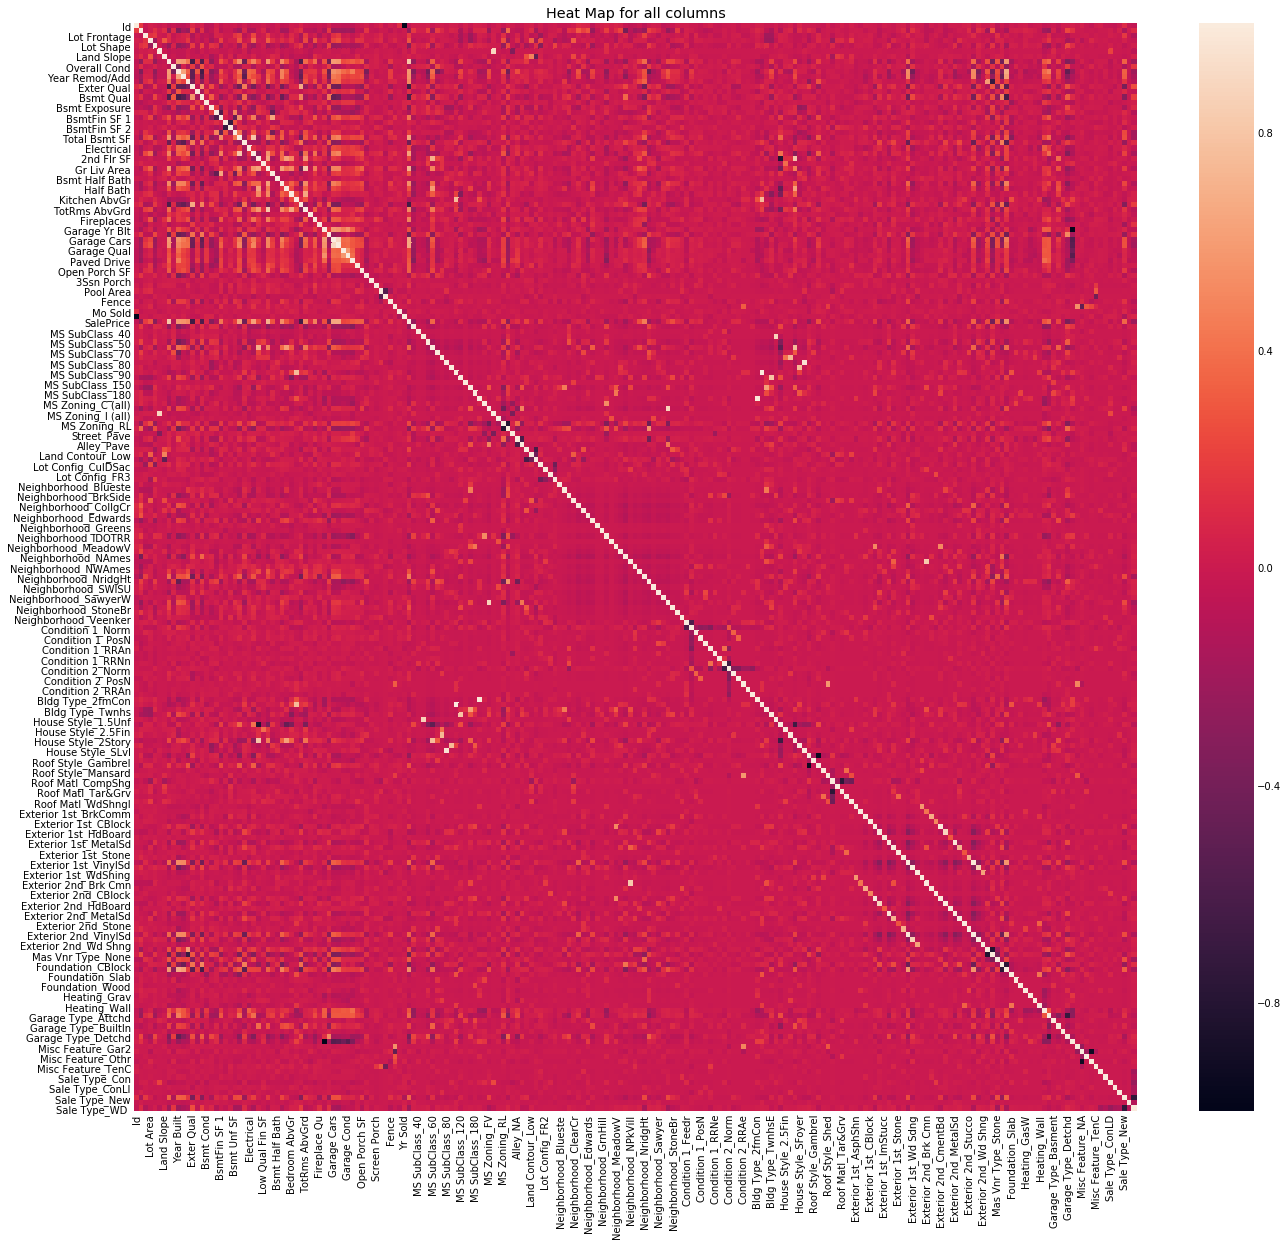

In [7]:
fig, ax = plt.subplots(figsize=(20,20)) 
ax.set_title('Heat Map for all columns')
sns.heatmap(ames_train.corr(), ax = ax, annot=False, annot_kws={"size": 20})

In [8]:
ames_train[ames_train.columns[1:]].corr()['SalePrice'][:].sort_values(ascending=False)

SalePrice               1.000000
Overall Qual            0.800207
Gr Liv Area             0.697038
Garage Area             0.649897
Garage Cars             0.647781
Total Bsmt SF           0.629303
1st Flr SF              0.618486
Year Built              0.571849
Year Remod/Add          0.550370
Full Bath               0.537969
Foundation_PConc        0.529047
TotRms AbvGrd           0.504014
Mas Vnr Area            0.503579
Fireplaces              0.471093
Neighborhood_NridgHt    0.448647
BsmtFin SF 1            0.423856
Sale Type_New           0.358102
Garage Type_Attchd      0.357879
MS SubClass_60          0.355421
Exterior 1st_VinylSd    0.342146
Exterior 2nd_VinylSd    0.337563
Open Porch SF           0.333476
Wood Deck SF            0.326490
Mas Vnr Type_Stone      0.310026
Lot Area                0.296566
Paved Drive             0.290472
Bsmt Full Bath          0.283332
Half Bath               0.283001
Central Air_Y           0.277378
Roof Style_Hip          0.265224
Neighborho

In [9]:
def top_abs_corr(df, n):
    au_corr = df.corr().abs().unstack()
    au_corr = au_corr.sort_values(ascending=False).drop_duplicates()
    return au_corr[0:n]

print(top_abs_corr(ames_train, 20))

Sale Type_WD          Sale Type_WD            1.000000
Garage Yr Blt         Garage Type_NA          0.998504
Exterior 1st_CemntBd  Exterior 2nd_CmentBd    0.988379
Bldg Type_2fmCon      MS SubClass_190         0.977762
Exterior 2nd_VinylSd  Exterior 1st_VinylSd    0.977569
Exterior 2nd_MetalSd  Exterior 1st_MetalSd    0.976461
Yr Sold               Id                      0.975747
House Style_SLvl      MS SubClass_80          0.954552
Roof Style_Hip        Roof Style_Gable        0.948438
Misc Feature_NA       Misc Feature_Shed       0.926095
Utilities             MS Zoning_I (all)       0.894384
Garage Cars           Garage Area             0.893442
Exterior 1st_HdBoard  Exterior 2nd_HdBoard    0.885877
Neighborhood_Somerst  MS Zoning_FV            0.874854
MS SubClass_45        House Style_1.5Unf      0.869663
Exterior 1st_Wd Sdng  Exterior 2nd_Wd Sdng    0.859205
Mas Vnr Type_None     Mas Vnr Type_BrkFace    0.823329
Neighborhood_NPkVill  Exterior 2nd_Brk Cmn    0.822054
Gr Liv Are

In [10]:
ss = StandardScaler()

In [11]:
#Split df so that dummy variables are not standardized
ames1=ames_train.iloc[:,0:58]
ames2=ames_train.iloc[:,59:]

In [12]:
#Standarizing all other columns
ames1s = ss.fit_transform(ames1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
#convert them back to DataFrames
ames1s=pd.DataFrame(ames1s, columns = ames_train.iloc[:,0:58].columns)
ames2=pd.DataFrame(ames2, columns = ames_train.iloc[:,59:].columns)

In [14]:
#combine them back
ames_train_s = pd.concat([ames1s,ames2], axis=1,sort=False)

In [15]:
X = ames_train_s
y = ames_train.SalePrice

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model = linreg.fit(X_train,y_train)
linreg_scores = cross_val_score(model, X, y, cv=10)

print (linreg_scores)
print (np.mean(linreg_scores))

[ 7.04715072e-01 -1.82772009e+14 -1.46212048e+27 -7.19105224e+16
 -3.44723105e+16 -7.37951479e+18  9.02951624e-01 -1.67660606e+21
  8.88582346e-01 -1.08157521e+20]
-1.4621222729706836e+26


In [17]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

80.92077367285758


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


In [18]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly worst off than baseline

[0.87173767 0.84298912 0.89459921 0.92150552 0.61635869 0.89014067
 0.91531292 0.89784572 0.87652958 0.72810683]
0.8455125939313499


In [19]:
lasso.fit(X_train, y_train)

Lasso(alpha=80.92077367285758, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

variable          coef      abs_coef
199     Misc Feature_Gar2  60125.580930  60125.580930
98   Neighborhood_GrnHill  57532.484135  57532.484135
113  Neighborhood_StoneBr  42487.760395  42487.760395
107  Neighborhood_NridgHt  36207.050025  36207.050025
82       Land Contour_HLS  24856.257732  24856.257732
119      Condition 1_PosN  23648.979634  23648.979634
106  Neighborhood_NoRidge  23082.961845  23082.961845
28            Gr Liv Area  18335.074293  18335.074293
134      Bldg Type_TwnhsE -15592.301070  15592.301070
133       Bldg Type_Twnhs -15378.431755  15378.431755
7            Overall Qual  15004.099057  15004.099057
162   Exterior 1st_Stucco -14051.258133  14051.258133
154  Exterior 1st_BrkFace  13643.553281  13643.553281
194   Garage Type_Basment -12300.075655  12300.075655
205         Sale Type_Con  10993.686282  10993.686282
68        MS SubClass_120 -10676.659398  10676.659398
84       Land Contour_Lvl  10671.745189  10671.745189
151     Roof Matl_WdShngl   8893.972202   8893.972202
95   Neighborhood_Edwards  -8726.995156   8726.995156
42            Garage Cars   8676.076535   8676.076535

In [21]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(212, 3)
97
Percent variables zeroed out: 0.45754716981132076


In [22]:
lasso_coefs2 = lasso_coefs[:(212-97)]
lasso_coefs2 = lasso_coefs2.drop(['coef','abs_coef'], axis=1)
lasso_coefs2

variable
199     Misc Feature_Gar2
98   Neighborhood_GrnHill
113  Neighborhood_StoneBr
107  Neighborhood_NridgHt
82       Land Contour_HLS
119      Condition 1_PosN
106  Neighborhood_NoRidge
28            Gr Liv Area
134      Bldg Type_TwnhsE
133       Bldg Type_Twnhs
7            Overall Qual
162   Exterior 1st_Stucco
154  Exterior 1st_BrkFace
194   Garage Type_Basment
205         Sale Type_Con
68        MS SubClass_120
84       Land Contour_Lvl
151     Roof Matl_WdShngl
95   Neighborhood_Edwards
42            Garage Cars
118      Condition 1_PosA
136    House Style_1Story
35           Kitchen Qual
94   Neighborhood_Crawfor
85     Lot Config_CulDSac
55               Misc Val
209         Sale Type_New
147     Roof Matl_CompShg
156  Exterior 1st_CemntBd
145    Roof Style_Mansard
108  Neighborhood_OldTown
117      Condition 1_Norm
139    House Style_2Story
8            Overall Cond
105   Neighborhood_NWAmes
74           MS Zoning_FV
200       Misc Feature_NA
12             Exter Qual
112  Neighborhood_Somerst
157  Exterior 1st_HdBoard
125      Condition 2_Norm
38             Fireplaces
16          Bsmt Exposure
29         Bsmt Full Bath
51           Screen Porch
176   Exterior 2nd_Stucco
192         Central Air_Y
99    Neighborhood_IDOTRR
9              Year Built
11           Mas Vnr Area
34          Kitchen AbvGr
61         MS SubClass_50
141      House Style_SLvl
96   Neighborhood_Gilbert
72        MS SubClass_190
18           BsmtFin SF 1
184      Foundation_PConc
36          TotRms AbvGrd
52              Pool Area
44            Garage Qual
164  Exterior 1st_Wd Sdng
31              Full Bath
211         Sale Type_WD 
116     Condition 1_Feedr
76           MS Zoning_RH
37             Functional
3                Lot Area
183     Foundation_CBlock
144        Roof Style_Hip
103    Neighborhood_NAmes
195   Garage Type_BuiltIn
14              Bsmt Qual
46            Paved Drive
41          Garage Finish
5               Utilities
32              Half Bath
6              Land Slope
88      Lot Config_Inside
78           MS Zoning_RM
17         BsmtFin Type 1
47           Wood Deck SF
23             Heating QC
40          Garage Yr Blt
10         Year Remod/Add
120      Condition 1_RRAe
54                  Fence
33          Bedroom AbvGr
15              Bsmt Cond
163  Exterior 1st_VinylSd
25             1st Flr SF
48          Open Porch SF
63         MS SubClass_70
2            Lot Frontage
83       Land Contour_Low
24             Electrical
181     Mas Vnr Type_None
142      Roof Style_Gable
53                Pool QC
57                Yr Sold
43            Garage Area
111  Neighborhood_SawyerW
49         Enclosed Porch
27        Low Qual Fin SF
13             Exter Cond
92   Neighborhood_ClearCr
56                Mo Sold
182    Mas Vnr Type_Stone
179  Exterior 2nd_Wd Shng
19         BsmtFin Type 2
1                     PID
50             3Ssn Porch
22          Total Bsmt SF
20           BsmtFin SF 2
4               Lot Shape
174  Exterior 2nd_Plywood

In [23]:
X2 = X[["Misc Feature_Gar2",
"Neighborhood_GrnHill",
"Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"Land Contour_HLS",
"Condition 1_PosN",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Bldg Type_TwnhsE",
"Bldg Type_Twnhs",
"Overall Qual",
"Exterior 1st_Stucco",
"Exterior 1st_BrkFace",
"Garage Type_Basment",
"Sale Type_Con",
"MS SubClass_120",
"Land Contour_Lvl",
"Roof Matl_WdShngl",
"Neighborhood_Edwards",
"Garage Cars",
"Condition 1_PosA",
"House Style_1Story",
"Kitchen Qual",
"Neighborhood_Crawfor",
"Lot Config_CulDSac",
"Misc Val",
"Sale Type_New",
"Roof Matl_CompShg",
"Exterior 1st_CemntBd",
"Roof Style_Mansard",
"Neighborhood_OldTown",
"Condition 1_Norm",
"House Style_2Story",
"Overall Cond",
"Neighborhood_NWAmes",
"MS Zoning_FV",
"Misc Feature_NA",
"Exter Qual",
"Neighborhood_Somerst",
"Exterior 1st_HdBoard",
"Condition 2_Norm",
"Fireplaces",
"Bsmt Exposure",
"Bsmt Full Bath",
"Screen Porch",
"Exterior 2nd_Stucco",
"Central Air_Y",
"Neighborhood_IDOTRR",
"Year Built",
"Mas Vnr Area",
"Kitchen AbvGr",
"MS SubClass_50",
"House Style_SLvl",
"Neighborhood_Gilbert",
"MS SubClass_190",
"BsmtFin SF 1",
"Foundation_PConc",
"TotRms AbvGrd",
"Pool Area",
"Garage Qual",
"Exterior 1st_Wd Sdng",
"Full Bath",
"Condition 1_Feedr",
"MS Zoning_RH",
"Functional",
"Lot Area",
"Foundation_CBlock",
"Roof Style_Hip",
"Neighborhood_NAmes",
"Garage Type_BuiltIn",
"Bsmt Qual",
"Paved Drive",
"Garage Finish",
"Utilities",
"Half Bath",
"Land Slope",
"Lot Config_Inside",
"MS Zoning_RM",
"BsmtFin Type 1",
"Wood Deck SF",
"Heating QC",
"Garage Yr Blt",
"Year Remod/Add",
"Condition 1_RRAe",
"Fence",
"Bedroom AbvGr",
"Bsmt Cond",
"Exterior 1st_VinylSd",
"1st Flr SF",
"Open Porch SF",
"MS SubClass_70",
"Lot Frontage",
"Land Contour_Low",
"Electrical",
"Mas Vnr Type_None",
"Roof Style_Gable",
"Pool QC",
"Yr Sold",
"Garage Area",
"Neighborhood_SawyerW",
"Enclosed Porch",
"Low Qual Fin SF",
"Exter Cond",
"Neighborhood_ClearCr",
"Mo Sold",
"Mas Vnr Type_Stone",
"Exterior 2nd_Wd Shng",
"BsmtFin Type 2",
"PID",
"3Ssn Porch",
"Total Bsmt SF",
"BsmtFin SF 2",
"Lot Shape",
"Exterior 2nd_Plywood"]]

In [24]:
y = ames_train.SalePrice

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, random_state=20 , train_size=0.7 , test_size=0.3)

linreg = LinearRegression()
model2 = linreg.fit(X_train2,y_train2)
linreg_scores2 = cross_val_score(model2, X2, y, cv=10)

print (linreg_scores2)
print (np.mean(linreg_scores2))

[0.86701272 0.86419311 0.86767684 0.92593184 0.64084549 0.88363966
 0.90313532 0.90649393 0.87915006 0.71587208]
0.8453951042229552


In [25]:
#Try Lasso

optimal_lasso = LassoCV(n_alphas=1000, cv=10, verbose=1)
optimal_lasso.fit(X_train2, y_train2)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s 

62.65401622935269


In [26]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X, y, cv=10)

print (lasso_scores)
print (np.mean(lasso_scores))
#slightly better than benchmark

[0.87051515 0.8406124  0.89533268 0.92414726 0.61821866 0.89120438
 0.91320362 0.89921426 0.87722008 0.7279704 ]
0.8457638885614035


In [27]:
lasso_model = lasso.fit(X_train2, y_train2)
lasso_model

Lasso(alpha=62.65401622935269, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
lasso_coefs = pd.DataFrame({'variable':X_train2.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head()

variable          coef      abs_coef
1  Neighborhood_GrnHill  73341.822174  73341.822174
0     Misc Feature_Gar2  71891.366025  71891.366025
2  Neighborhood_StoneBr  43704.332819  43704.332819
3  Neighborhood_NridgHt  36731.525229  36731.525229
4      Land Contour_HLS  26884.934088  26884.934088

In [29]:
print(lasso_coefs.shape)
print(np.sum((lasso.coef_ == 0)))                                                          
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(lasso_coefs.shape[0]))
#okay, too many variables. Need to scale down

(114, 3)
1
Percent variables zeroed out: 0.008771929824561403


In [30]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train2, y_train2)

print(optimal_ridge.alpha_)

1.414991297434576


In [31]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X, y, cv=10)

print (ridge_scores)
print (np.mean(ridge_scores))

[0.86963759 0.84354014 0.90404442 0.92550331 0.6124793  0.89494722
 0.90581466 0.90065871 0.87607294 0.7168578 ]
0.8449556085252847


In [32]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(X_train2, y_train2)

print (optimal_enet.alpha_)
print (optimal_enet.l1_ratio_)
#Full lasso model is preferred

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

62.65401622935269
1.0


.................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    5.2s finished


In [33]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X, y, cv=10)

print (enet_scores)
print (np.mean(enet_scores))
#same as lasso score

[0.87051515 0.8406124  0.89533268 0.92414726 0.61821866 0.89120438
 0.91320362 0.89921426 0.87722008 0.7279704 ]
0.8457638885614035


In [34]:
lasso_model = lasso.fit(X_train2, y_train2)

In [35]:
lasso_model.score(X_train2, y_train2)

0.9004000154852798

In [36]:
lasso_model.score(X_test2, y_test2)

0.8907703914616381

In [37]:
lasso_scores.mean()

0.8457638885614035

In [38]:
y_pred = lasso_model.predict(X_test2)

In [39]:
r2_score(y_test2, y_pred)

0.8907703914616381

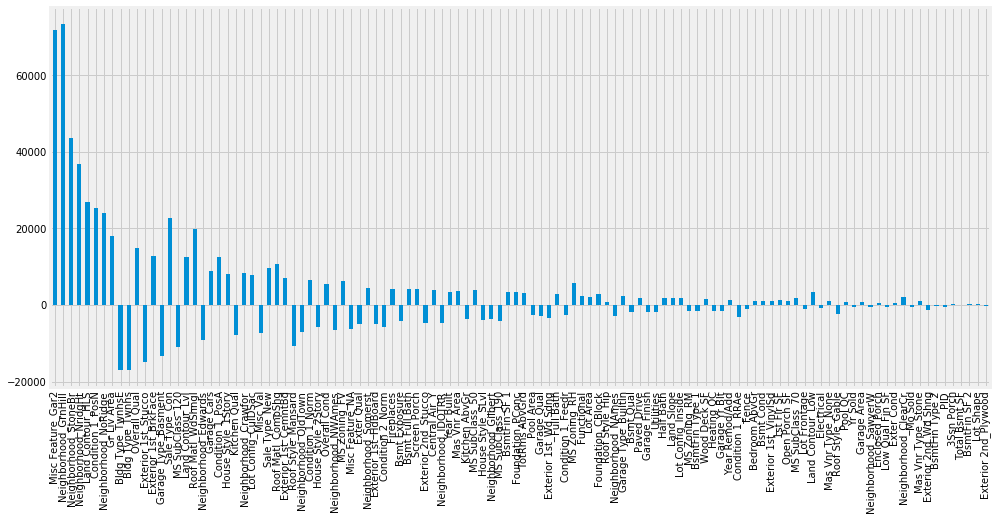

In [40]:
pd.Series(lasso.coef_, index=X2.columns).plot.bar(figsize=(15, 7))

In [41]:
residuals = y_test - y_pred

In [42]:
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)

print(lasso_mse)
print(lasso_rmse)

721580038.6505569
26862.241876853037


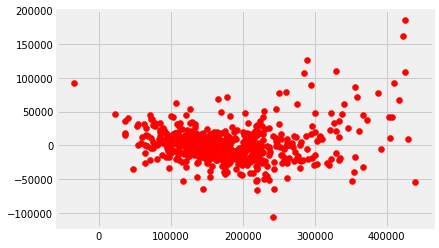

In [43]:
plt.scatter(y_pred, residuals,color='red')

In [44]:
ames_test = pd.read_csv('datasets/test.csv')

In [45]:
explore(ames_test)

(879, 80)

     Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1   NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   

  Condition 1 Condition 2 Bldg Type House Style  Overall 

In [46]:
ames_test.loc[(ames_test['Pool QC'].isin([np.nan]))]

Id         PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    2658   902301120          190        RM          69.0      9142   Pave   
1    2718   905108090           90        RL           NaN      9662   Pave   
2    2414   528218130           60        RL          58.0     17104   Pave   
3    1989   902207150           30        RM          60.0      8520   Pave   
4     625   535105100           20        RL           NaN      9500   Pave   
5     333   923228370          160        RM          21.0      1890   Pave   
6    1327   902427150           20        RM          52.0      8516   Pave   
7     858   907202130           20        RL           NaN      9286   Pave   
8      95   533208090          160        FV          39.0      3515   Pave   
9    1568   914476010           20        RL          75.0     10125   Pave   
10   2482   531452100          120        RL          50.0      7175   Pave   
11   1364   903455140           30        RM          60.0      7200   Pave   
12   2584   535303050           20        RL          75.0     11310   Pave   
13    818   906230030           90        RL           NaN      7976   Pave   
14   2673   903206160           70        RL          69.0     11737   Pave   
15   2089   905480180           20        RL          60.0      9060   Pave   
16   1297   902128150          190        RM          60.0     10800   Pave   
17    790   905451300           20        RL          68.0      9571   Pave   
18   2616   535425040           20        RL          80.0     10800   Pave   
19    720   902330040           70        RM         121.0     17671   Pave   
20    222   905105070           20        RL           NaN      8246   Pave   
21    557   532354160           20        RL           NaN      8499   Pave   
22   1148   531451020          120        RL          50.0      8012   Pave   
23   2766   906475050           80        RL           NaN     21453   Pave   
24    534   531363010           20        RL          80.0      9605   Pave   
25   1452   907227050           20        RL          60.0      7180   Pave   
26    630   535150070           50        RL           NaN     12513   Pave   
27   2648   902125020           70        RM          50.0      9000   Pave   
28    125   534425310           85        RL          80.0      8800   Pave   
29   1904   534451020           50        RL          51.0      3500   Pave   
30   1670   527404150           20        RL           NaN      7340   Pave   
31    756   903458170           30        RM          52.0      6240   Pave   
32    717   902326030           70        RM          65.0     11700   Pave   
33   1032   527378020           20        RL          80.0     10000   Pave   
34    852   907196060           20        RL          75.0     11166   Pave   
35   1731   528218100           60        RL          58.0     13204   Pave   
36   2639   902103090           50        RM          60.0      5520   Pave   
37   2071   905228020           20        RL           NaN      9000   Pave   
38   1267   535451010           20        RL          74.0      8892   Pave   
39   1851   533242080           20        FV          73.0      7321   Pave   
40    567   533210010          160        FV          40.0      3951   Pave   
41   2439   528280100           60        RL           NaN     11214   Pave   
42   1898   534427140           20        RL          75.0      7388   Pave   
43    647   535351050           20        RL          75.0     14559   Pave   
44   2256   916226090          120        RL          46.0      4054   Pave   
45    979   923228150          160        RM          21.0      1533   Pave   
46   1444   907196050           60        RL          68.0     11250   Pave   
47   2485   531479030           20        RH          60.0      7800   Pave   
48    157   535350040           20        RL          74.0      5868   Pave   
49     88   532377100           20        RL          75.

In [47]:
#Replacing the np.nan cells to their respective column values

#changing to 0 for no lot frontage, 160 entries
ames_test['Lot Frontage'] = ames_test['Lot Frontage'].replace({np.nan:0})
#Changing to NA for no alley access
ames_test['Alley'] = ames_test['Alley'].replace({np.nan:'NA'})

#both 'Mas Vnr Type' and 'Mas Vnr Area' are 1 entry that are tied to each other
ames_test['Mas Vnr Type'] = ames_test['Mas Vnr Type'].replace({np.nan:'None'})
ames_test['Mas Vnr Area'] = ames_test['Mas Vnr Area'].replace({np.nan:0})

#25 entries without basement
ames_test['Bsmt Qual'] = ames_test['Bsmt Qual'].replace({np.nan:'NA'})
ames_test['Bsmt Cond'] = ames_test['Bsmt Cond'].replace({np.nan:'NA'})
ames_test['Bsmt Exposure'] = ames_test['Bsmt Exposure'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 1'] = ames_test['BsmtFin Type 1'].replace({np.nan:'NA'})
ames_test['BsmtFin Type 2'] = ames_test['BsmtFin Type 2'].replace({np.nan:'NA'})

#1 electrical entry without additional information
ames_test.iloc[635, ames_test.columns.get_loc('Electrical')] = 'Mixed'

#All fireplace Qu with np.nan is does not have a fireplace,422 entries
ames_test['Fireplace Qu'] = ames_test['Fireplace Qu'].replace({np.nan:'NA'})

#All except for row765, does not have a garage. 44 entries without garage
ames_test['Garage Type'] = ames_test['Garage Type'].replace({np.nan:'NA'})
ames_test.iloc[765, ames_test.columns.get_loc('Garage Yr Blt')] = ames_test.iloc[765, ames_test.columns.get_loc('Year Remod/Add')]
ames_test['Garage Yr Blt'] = ames_test['Garage Yr Blt'].replace({np.nan:0})
ames_test['Garage Finish'] = ames_test['Garage Finish'].replace({np.nan:'NA'})
ames_test['Garage Qual'] = ames_test['Garage Qual'].replace({np.nan:'NA'})
ames_test['Garage Cond'] = ames_test['Garage Cond'].replace({np.nan:'NA'})


#All Pool QC with np.nan has pool area of 0
ames_test['Pool QC'] = ames_test['Pool QC'].replace({np.nan:'NA'})
ames_test['Fence'] = ames_test['Fence'].replace({np.nan:'NA'})
ames_test['Misc Feature'] = ames_test['Misc Feature'].replace({np.nan:'NA'})

In [48]:
def transform2(col):
    for i in col:
        le.fit(ames_test[i])
        list(le.classes_)
        ames_test[i] = le.transform(ames_test[i])

transform2(columns)

In [49]:
ames_test = pd.get_dummies(data = ames_test, prefix=column2, columns = column2, drop_first=True)

In [50]:
ames_test['Misc Feature_Gar2']=0
ames_test['Neighborhood_GrnHill']=0
ames_test['Roof Matl_CompShg']=0

In [51]:
ames1_test=ames_test.iloc[:,0:58]
ames2_test=ames_test.iloc[:,58:]

In [52]:
#Standarizing all other columns
ames1s_test = ss.fit_transform(ames1_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [53]:
#convert them back to DataFrames
ames1s_test=pd.DataFrame(ames1s_test, columns = ames_test.iloc[:,0:58].columns)
ames2_test=pd.DataFrame(ames2_test, columns = ames_test.iloc[:,58:].columns)

In [55]:
#combine them back
ames_test_s = pd.concat([ames1s_test,ames2_test], axis=1,sort=False)

In [56]:
X_test_final = ames_test_s[['Misc Feature_Gar2',
'Neighborhood_GrnHill',
'Roof Matl_CompShg',   
"Neighborhood_StoneBr",
"Neighborhood_NridgHt",
"Land Contour_HLS",
"Condition 1_PosN",
"Neighborhood_NoRidge",
"Gr Liv Area",
"Bldg Type_TwnhsE",
"Bldg Type_Twnhs",
"Overall Qual",
"Exterior 1st_Stucco",
"Exterior 1st_BrkFace",
"Garage Type_Basment",
"Sale Type_Con",
"MS SubClass_120",
"Land Contour_Lvl",
"Roof Matl_WdShngl",
"Neighborhood_Edwards",
"Garage Cars",
"Condition 1_PosA",
"House Style_1Story",
"Kitchen Qual",
"Neighborhood_Crawfor",
"Lot Config_CulDSac",
"Misc Val",
"Sale Type_New",
"Exterior 1st_CemntBd",
"Roof Style_Mansard",
"Neighborhood_OldTown",
"Condition 1_Norm",
"House Style_2Story",
"Overall Cond",
"Neighborhood_NWAmes",
"MS Zoning_FV",
"Misc Feature_NA",
"Exter Qual",
"Neighborhood_Somerst",
"Exterior 1st_HdBoard",
"Condition 2_Norm",
"Fireplaces",
"Bsmt Exposure",
"Bsmt Full Bath",
"Screen Porch",
"Exterior 2nd_Stucco",
"Central Air_Y",
"Neighborhood_IDOTRR",
"Year Built",
"Mas Vnr Area",
"Kitchen AbvGr",
"MS SubClass_50",
"House Style_SLvl",
"Neighborhood_Gilbert",
"MS SubClass_190",
"BsmtFin SF 1",
"Foundation_PConc",
"TotRms AbvGrd",
"Pool Area",
"Garage Qual",
"Exterior 1st_Wd Sdng",
"Full Bath",
"Condition 1_Feedr",
"MS Zoning_RH",
"Functional",
"Lot Area",
"Foundation_CBlock",
"Roof Style_Hip",
"Neighborhood_NAmes",
"Garage Type_BuiltIn",
"Bsmt Qual",
"Paved Drive",
"Garage Finish",
"Utilities",
"Half Bath",
"Land Slope",
"Lot Config_Inside",
"MS Zoning_RM",
"BsmtFin Type 1",
"Wood Deck SF",
"Heating QC",
"Garage Yr Blt",
"Year Remod/Add",
"Condition 1_RRAe",
"Fence",
"Bedroom AbvGr",
"Bsmt Cond",
"Exterior 1st_VinylSd",
"1st Flr SF",
"Open Porch SF",
"MS SubClass_70",
"Lot Frontage",
"Land Contour_Low",
"Electrical",
"Mas Vnr Type_None",
"Roof Style_Gable",
"Pool QC",
"Yr Sold",
"Garage Area",
"Neighborhood_SawyerW",
"Enclosed Porch",
"Low Qual Fin SF",
"Exter Cond",
"Neighborhood_ClearCr",
"Mo Sold",
"Mas Vnr Type_Stone",
"Exterior 2nd_Wd Shng",
"BsmtFin Type 2",
"PID",
"3Ssn Porch",
"Total Bsmt SF",
"BsmtFin SF 2",
"Lot Shape",
"Exterior 2nd_Plywood"]]

In [57]:
X_test_final.shape

(879, 114)

In [59]:
y_pred = lasso_model.predict(X_test_final)
y_pred = pd.DataFrame(y_pred, columns = ['SalePrice'])

In [60]:
final = pd.concat([ames_test.iloc[:,0],y_pred], axis=1)

In [61]:
final = final.sort_values(by=['Id'],ascending=True)
final

Id      SalePrice
704     2  167344.813738
706     4  131346.913385
120     6  168245.072875
312     7  201394.402164
401    17  178097.461047
316    18  204977.996823
791    22  187589.132276
608    27  198852.578126
391    31  171546.554057
753    36  187477.580770
317    39  236029.463418
324    40  194954.388853
710    42  201261.660428
453    46  215026.565918
168    53  169795.642273
620    58  176282.770422
201    61  179598.263340
643    72  215788.646144
469    79  172579.189630
441    80  146090.506177
393    82  181119.683805
479    83  128253.978258
587    85  202793.034929
49     88  161141.825602
794    92  177836.066544
345    93  177137.555885
8      95  132593.031474
636   102  181613.291052
648   103  191323.830334
346   106  165514.860811
340   107  151549.385832
590   110  184285.275207
108   114  179078.988822
141   116  170081.346656
686   117  158099.730329
830   118  185444.877567
28    125  179424.997649
814   126  160902.616428
142   127  164004.302105
667   128  177629.148149
708   134  159804.775004
134   135  208033.768776
847   137  156570.651595
267   143  156568.625728
740   147  154046.504208
516   148  188800.318747
477   150  132132.575025
676   156  188944.813124
48    157  187627.895444
222   159  179877.320639
356   161  141990.790868
651   167  160749.379866
233   170  187820.792322
257   171  141435.369237
856   175  148266.040648
93    179  125259.300369
744   181  140541.987250
51    186   98246.881053
188   193   92214.225992
448   194  158471.054817
599   206  170937.099434
117   208  116403.632371
795   210  150268.630124
363   211  128488.153381
497   212  139676.985198
804   214  100294.514261
407   215  155488.118245
110   217  152281.565098
20    222  185160.106839
133   227  175822.451863
813   228  178707.620613
843   233  181184.307879
511   235  190020.515870
290   238  181551.797713
609   241  174288.795738
395   252  161207.044768
534   253  158189.363098
541   256  192916.493625
574   257  214447.612806
747   258  166108.262581
344   259  154977.177968
148   261  171992.677930
87    263  197437.146581
408   266  163471.064879
762   267  149438.374203
578   270  186611.080034
700   271  177216.392924
528   276  134438.237262
743   285  205744.271671
634   288  171138.003337
323   289  123698.029656
225   290  180648.315343
315   291  135125.229855
181   292  120066.230649
632   293  114913.454229
136   294  163741.156525
631   295  165412.791765
82    304  163711.599596
245   322  177967.301509
571   326  189205.241574
678   327  160667.823763
192   328  226334.477494
232   331  193912.819529
157   332  144265.710388
5     333  155887.732986
389   335  151097.687290
869   337  140949.120513
247   342  139507.998196
111   343  185223.901917
767   347  174534.799079
629   350  186137.007997
857   352  219937.857262
745   358  228358.107080
473   359  166024.536145
770   360  150126.712655
872   368  224834.787600
693   369  223083.258945
727   373  162003.994840
413   377  133624.791953
742   383  186554.160458
112   386  146708.852658
456   387  156151.153549
58    390  152259.067928
185   391  160464.890418
55    395  174202.451415
74    397  185214.267356
275   398  206135.681011
419   401  185945.423068
863   404  148951.431497
724   408  193261.001352
326   409  175277.082693
558   410  150647.315643
531   418  140875.241846
238   422  234386.762428
86    427  203645.068874
426   431  213821.799475
164   433  218672.539018
71    437  194054.992593
404   438  202127.966250
383   442  204219.498966
798   447  192402.300459
302   459  187032.373550
165   460  172872.482216
842   464  191283.037777
808   465  152293.134337
501   467  168693.586792
224   468  177967.537907
831   474  160086.773199
434   480  165457.750279
187   481  176509.079212
379   483  235417.344831
249   488  158429.748394
650   492  160883.135294
803   494  169356.867390
416   499  190948.484222
230   500  185434.996826
65    501  203377.572365
298   503  186721.175738
286   506  183214.807932
751   5

In [62]:
final.to_csv("datasets/final.csv", index=False) 